# Thinkful Capstone \#1 - Million Songs Subset

## Introduction:
For this capstone, I analyzed a [subset](http://static.echonest.com/millionsongsubset_full.tar.gz) (10,000 rows) extracted randomly from a much larger (1,000,000 rows) dataset, which is known as the [Million Song Dataset](http://millionsongdataset.com/), for obvious reasons. I would have preferred to use the entire million-song dataset, but I found that my Jupyter notebook stopped working and my computer froze every time I tried to load the entire dataset. So, for the sake of practicality, only the randomly selected subset of 10,000 songs was used in this analysis. The information was originally gathered by a collaboration of researchers from Columbia University, with the help of extraction tools from LabROSA, The Echo Nest, and Musicbrainz, although many of the features gathered via those tools were removed from the dataset before I did my analysis, due to issues with relevance or missing information.

Throughout this report, I will go through the process of loading the dataset, removing non-useful values, cleaning to make the formatting constant, and finally, the analysis of the collected features, with special attention toward visualizations that indicate important observations.

In [1]:
import matplotlib.pyplot as plt    #Visualization library
import seaborn as sns              #More visualization
import pandas as pd                #Dataframes
import numpy as np                 #Arrays

#Makes visualization work in Jupyter
%matplotlib inline                 

import scipy
from scipy.optimize import curve_fit    #Curve of best fit on plot

# 1. Data Loading, Extraction, and Cleaning
One issue that I ran into when trying to perform this analysis was that the summary file for this dataset was in a format (hdf5) that I'd never worked with before. Eventually, I figured out how to load the file into this notebook and extract all of the contained features, sorted into three categories of 'metadata', 'analysis', and 'musicbrainz,' referring to which extrcation tool was used to gather each set of features. 

In [2]:
import h5py as hdf

#Load data subset summary file
subset = 'MillionSongSubset/AdditionalFiles/subset_msd_summary_file.h5'   #path to summary file

f = hdf.File(subset, 'r')
list(f.keys())

['analysis', 'metadata', 'musicbrainz']

In [3]:
dset1 = f.get('metadata')
dset1 = np.array(dset1['songs'])
features1 = dset1.dtype.names
print(features1)

('analyzer_version', 'artist_7digitalid', 'artist_familiarity', 'artist_hotttnesss', 'artist_id', 'artist_latitude', 'artist_location', 'artist_longitude', 'artist_mbid', 'artist_name', 'artist_playmeid', 'genre', 'idx_artist_terms', 'idx_similar_artists', 'release', 'release_7digitalid', 'song_hotttnesss', 'song_id', 'title', 'track_7digitalid')


In [4]:
dset2 = f.get('analysis')
dset2 = np.array(dset2['songs'])
features2 = dset2.dtype.names
print(features2)

('analysis_sample_rate', 'audio_md5', 'danceability', 'duration', 'end_of_fade_in', 'energy', 'idx_bars_confidence', 'idx_bars_start', 'idx_beats_confidence', 'idx_beats_start', 'idx_sections_confidence', 'idx_sections_start', 'idx_segments_confidence', 'idx_segments_loudness_max', 'idx_segments_loudness_max_time', 'idx_segments_loudness_start', 'idx_segments_pitches', 'idx_segments_start', 'idx_segments_timbre', 'idx_tatums_confidence', 'idx_tatums_start', 'key', 'key_confidence', 'loudness', 'mode', 'mode_confidence', 'start_of_fade_out', 'tempo', 'time_signature', 'time_signature_confidence', 'track_id')


In [5]:
dset3 = f.get('musicbrainz')
dset3 = np.array(dset3['songs'])
features3 = dset3.dtype.names
print(features3)

('idx_artist_mbtags', 'year')


## Dataset Creation
Once I had extracted all of the features, I combined them into one dataset, to make it easier to work access and clean. The initial size of the dataset, before any cleaning was performed, was 10,000 rows (representing each song) by 53 columns (representing each of the extracted features). Although it's possible that all 53 features contain important information, I needed to make sure before wasting time on analysis.

In [6]:
#Combine the three datasets into one dataframe
headers = features1 + features2 + features3
headers = sorted(headers)   #Alphabetize

all_data = pd.DataFrame()

for category in features1:
    all_data[category] = list(dset1[category])
    
for category in features2:
    all_data[category] = list(dset2[category])
    
for category in features3:
    all_data[category] = list(dset3[category])

all_data = all_data.reindex(sorted(all_data.columns), axis=1)    #Alphabetize columns
all_data.shape    #Many features (probably need to reduce for analysis)

(10000, 53)

One issue with this dataset was that the string features were in a byte format, instead of the normal str, as shown below, within the analyzer_version, artist_id, and artist_location features, among several others.

In [7]:
all_data.head()

,analysis_sample_rate,analyzer_version,artist_7digitalid,artist_familiarity,artist_hotttnesss,artist_id,artist_latitude,artist_location,artist_longitude,artist_mbid,...,song_hotttnesss,song_id,start_of_fade_out,tempo,time_signature,time_signature_confidence,title,track_7digitalid,track_id,year
0,22050,b'',29785,0.780462,0.574275,b'ARMQHX71187B9890D3',NaN,"b'Atlanta, GA'",NaN,b'bc5e2ad6-0a4a-4d90-b911-e9a7e6861727',...,0.597641,b'SOVLGJY12A8C13FBED',275.528,173.205,5,0.120,b'Deep Sea Creature',2442524,b'TRACCVZ128F4291A8A',2001
1,22050,b'',167867,0.561590,0.420570,b'AR2PT4M1187FB55B1A',NaN,b'',NaN,b'd54ea4a6-0b9c-4e47-bed0-289ae9ff4037',...,NaN,b'SOGDQZK12A8C13F37C',184.128,150.955,4,0.600,b'No Quieras Marcharte',2423472,b'TRACCMH128F428E4CD',1984
2,22050,b'',7725,0.687687,0.406686,b'ARDI88R1187B98DAB2',NaN,b'',NaN,b'fd87374e-ffde-4d36-89a8-8a073f795666',...,0.588922,b'SODMVJR12A6D4F985D',216.300,93.056,4,1.000,b'If I...',507029,b'TRACCSW128F148C7C3',0
3,22050,b'',2799,0.391741,0.291265,b'ARUKJUP12086C14589',NaN,b'',NaN,b'8a5f2736-bcde-4a2e-8d50-72631d66a7ef',...,NaN,b'SOIWBDR12A8C13A4AC',278.386,127.113,1,0.446,"b""Werther - Lyric Drama in four Acts/Act I/Alo...",3343102,b'TRACCXJ128F428F0CF',0
4,22050,b'',74269,0.593416,0.395710,b'ARZEWUR1187FB53DC8',50.45663,"b'Belgica -- Namur, Namur/Ghent, East Flanders'",4.87137,b'0be59867-0da4-4e45-9b64-728cdf25487c',...,NaN,b'SOHCCIA12AC907577F',79.203,90.660,3,0.524,b'Ad Te Clamamus Exsvles Mortva Liberi',8688607,b'TRACCVS12903D014F8',2010


## String Conversion to UTF-8
So, my first step was to convert all of the byte strings to a more easily analyzable format. The UTF-8 format made it much easier to identify empty strings and NaN values within those features.

In [8]:
#Decode all bytes strings to the same str format

for header in headers:
    if isinstance(all_data[header][0], bytes):
        newtitle = []     #dummy variable

        for i in range(len(all_data[header])):
            newtitle.append((all_data[header][i]).decode('UTF-8'))

        all_data[header] = newtitle      


## NaN, 0, and Empty String Removal
Once formatting of the data had been completed, analysis of each feature had to be performed to see if any of the features could be removed because of lack of relevant information. If any features contained solely NaN or 0 values, they were removed from the dataset. This section provided some interesting information, because there were many more features than expected that had to be removed, including potentially interesting ones like genre. It's possible that the original dataset was missing all of that information, or perhaps my method of loading the dataset deprecated the data somehow and I lost the data stored in those features. After the removal of those features, the size of the dataset was (10000, 32), which meant that 21 features contained no usable information, which seems very significant.

In [9]:
all_data.columns

Index(['analysis_sample_rate', 'analyzer_version', 'artist_7digitalid',
       'artist_familiarity', 'artist_hotttnesss', 'artist_id',
       'artist_latitude', 'artist_location', 'artist_longitude', 'artist_mbid',
       'artist_name', 'artist_playmeid', 'audio_md5', 'danceability',
       'duration', 'end_of_fade_in', 'energy', 'genre', 'idx_artist_mbtags',
       'idx_artist_terms', 'idx_bars_confidence', 'idx_bars_start',
       'idx_beats_confidence', 'idx_beats_start', 'idx_sections_confidence',
       'idx_sections_start', 'idx_segments_confidence',
       'idx_segments_loudness_max', 'idx_segments_loudness_max_time',
       'idx_segments_loudness_start', 'idx_segments_pitches',
       'idx_segments_start', 'idx_segments_timbre', 'idx_similar_artists',
       'idx_tatums_confidence', 'idx_tatums_start', 'key', 'key_confidence',
       'loudness', 'mode', 'mode_confidence', 'release', 'release_7digitalid',
       'song_hotttnesss', 'song_id', 'start_of_fade_out', 'tempo',
       

In [10]:
#Remove 0, "", and NaN if representing missing data

#doesn't consider familiarity, hotttnesss, key, or mode, because 0 values are meaningful
temp_df = all_data.drop(['artist_familiarity', 'artist_hotttnesss', 'song_hotttnesss', 'key', 'mode'], axis=1)

#Replace 0 with NaN (easier to dropna later)
temp_df.replace(0,np.nan, inplace=True)

#Add back in the features that were previously ignored
for header in ['artist_familiarity', 'artist_hotttnesss', 'song_hotttnesss', 'key', 'mode']:
    temp_df[header] = all_data[header]
    
all_data = temp_df

#Replace empty strings with NaN
all_data.replace('',np.nan, inplace=True)   
all_data.head()

,analysis_sample_rate,analyzer_version,artist_7digitalid,artist_id,artist_latitude,artist_location,artist_longitude,artist_mbid,artist_name,artist_playmeid,...,time_signature_confidence,title,track_7digitalid,track_id,year,artist_familiarity,artist_hotttnesss,song_hotttnesss,key,mode
0,22050,NaN,29785,ARMQHX71187B9890D3,NaN,"Atlanta, GA",NaN,bc5e2ad6-0a4a-4d90-b911-e9a7e6861727,Mastodon,-1,...,0.120,Deep Sea Creature,2442524,TRACCVZ128F4291A8A,2001.0,0.780462,0.574275,0.597641,5,1
1,22050,NaN,167867,AR2PT4M1187FB55B1A,NaN,NaN,NaN,d54ea4a6-0b9c-4e47-bed0-289ae9ff4037,Los Chichos,1880,...,0.600,No Quieras Marcharte,2423472,TRACCMH128F428E4CD,1984.0,0.561590,0.420570,NaN,0,1
2,22050,NaN,7725,ARDI88R1187B98DAB2,NaN,NaN,NaN,fd87374e-ffde-4d36-89a8-8a073f795666,Foxy Brown,-1,...,1.000,If I...,507029,TRACCSW128F148C7C3,NaN,0.687687,0.406686,0.588922,1,1
3,22050,NaN,2799,ARUKJUP12086C14589,NaN,NaN,NaN,8a5f2736-bcde-4a2e-8d50-72631d66a7ef,Ramón Vargas;Vladimir Jurowski,20111,...,0.446,Werther - Lyric Drama in four Acts/Act I/Alors...,3343102,TRACCXJ128F428F0CF,NaN,0.391741,0.291265,NaN,7,1
4,22050,NaN,74269,ARZEWUR1187FB53DC8,50.45663,"Belgica -- Namur, Namur/Ghent, East Flanders",4.87137,0be59867-0da4-4e45-9b64-728cdf25487c,Enthroned,55656,...,0.524,Ad Te Clamamus Exsvles Mortva Liberi,8688607,TRACCVS12903D014F8,2010.0,0.593416,0.395710,NaN,2,1


In [11]:
#Drop all columns that only contain NaNs
all_data = all_data.dropna(axis = 'columns', how='all')

#Drop any rows that only contain NaNs (don't expect very many), then reset index
all_data = all_data.dropna(how='all')
all_data = all_data.reset_index(drop=True)

all_data.shape

(10000, 31)

In [12]:
#Which features were removed? (these features had NO usable information, all NaN or 0)
print("Removed Features: ")
for header in headers:
    if header not in all_data.columns:
        print(header)

Removed Features: 
analyzer_version
danceability
energy
genre
idx_artist_mbtags
idx_artist_terms
idx_bars_confidence
idx_bars_start
idx_beats_confidence
idx_beats_start
idx_sections_confidence
idx_sections_start
idx_segments_confidence
idx_segments_loudness_max
idx_segments_loudness_max_time
idx_segments_loudness_start
idx_segments_pitches
idx_segments_start
idx_segments_timbre
idx_similar_artists
idx_tatums_confidence
idx_tatums_start


## Non-Useful Features
Although all of the remaining features contain some usable values (i.e. not entirely NaN), some of the variables provide essentially the same information as others, so it doesn't make sense to keep all versions of the same list. Six features were removed due to repeated information, and three additional features were removed because they represented "confidence" values, which at this point in the program, I couldn't figure out how to use in my analysis.

In [13]:
#Remove non-useful features/columns of the dataset

# Determined that artist_id, artist_mbid, artist_7digitalid, artist_playmeid, and artist_name 
# are all equivalent methods of sorting by artist, so drop three of them
all_data = all_data.drop(['artist_id', 'artist_playmeid', 'artist_mbid', 'artist_7digitalid'], axis=1)

#release and release_7digitalid provide same information, drop one
all_data = all_data.drop(['release_7digitalid'],axis=1)

#song_id, track_7digitalid and track_id are equally useful, drop one
all_data = all_data.drop(['track_id', 'track_7digitalid'],axis=1)

#Remove confidence variables. Might be useful, but too early in the program to really understand how to use them
all_data = all_data.drop(['key_confidence','mode_confidence','time_signature_confidence'], axis=1)

all_data.shape

(10000, 21)

In [14]:
headers = list(all_data.columns)

## Features with Missing Data
The final step in cleaning this data before performing analysis is removal of any features that contain a large proportion of NaN values. Although I already removed features that had only NaNs, some of the remaining ones contain too many NaNs to be useful. So, first I visualized all of the features as a bar chart, relative to the proportion of NaNs contained within the set.

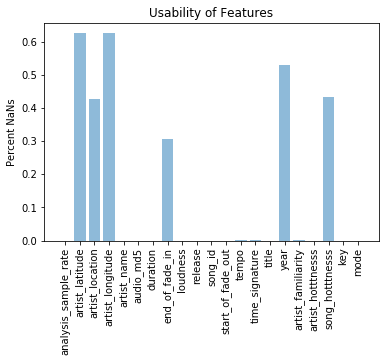

In [15]:
#Now that columns with all NaN values have been removed, we should also
#remove columns where "too many" values are NaN

percentNan = np.zeros(len(headers))

for i in range(len(headers)):
    try:
        percentNan[i] = len(all_data[headers[i]][np.isnan(all_data[headers[i]])])/10000
    except:
        percentNan[i] = len(all_data[headers[i]][pd.isnull(all_data[headers[i]])])/10000

#Plot all %Nan as bar chart
varNames = headers
y_pos = np.arange(len(varNames))

plt.bar(y_pos, percentNan, align='center', alpha=0.5)
plt.xticks(y_pos, varNames, rotation = 90)
plt.ylabel("Percent NaNs")
plt.title("Usability of Features")
plt.show()

I chose an arbitrary value of 50% (i.e. half of the data points missing) as "too many" NaNs, although in future analysis, that number could be adjusted. Additionally, although over 50% of the year values were NaNs, I expect that year would be a useful variable, so it was saved seperately from the dataset, to be used in later analysis. Finally, once the unusable features had been sorted, I plotted two bar charts, one showing the removed features, and the other showing the ones remaining in the dataset.

In [16]:
#Some of the variables from the above bar chart have far too many NaNs
drop_features = list()

for i in range(len(percentNan)):
    if percentNan[i] > 0.5:                 #arbitrary value of 50% NaN deemed "too many"
        drop_features.append(headers[i])

#save years for later independent analysis, possibly useful
years = all_data['year']


In [17]:
#Two bar graphs: removed and non-removed
drop_indices = list()

for feature in drop_features:
    drop_indices.append(headers.index(feature))
    
for name in drop_features:
    all_data = all_data.drop(name, axis = 1)
headers = list(all_data.columns)

badpercentNan = percentNan[drop_indices]
goodpercentNan = np.delete(percentNan, drop_indices)

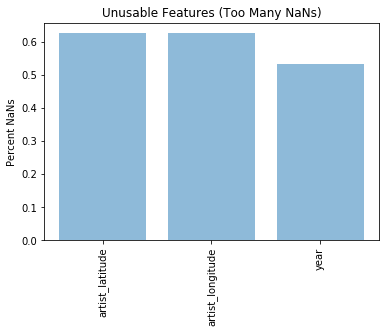

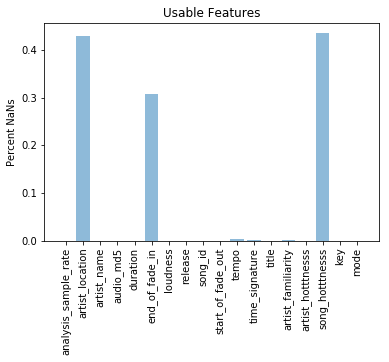

In [18]:
varNames_bad = drop_features
y_pos_bad = np.arange(len(varNames_bad))

plt.bar(y_pos_bad, badpercentNan, align='center', alpha=0.5)
plt.xticks(y_pos_bad, varNames_bad, rotation = 90)
plt.ylabel("Percent NaNs")
plt.title("Unusable Features (Too Many NaNs)")
plt.show()


varNames_good = headers
y_pos_good = np.arange(len(varNames_good))

plt.bar(y_pos_good, goodpercentNan, align='center', alpha=0.5)
plt.xticks(y_pos_good, varNames_good, rotation = 90)
plt.ylabel("Percent NaNs")
plt.title("Usable Features")
plt.show()


#Add years back into dataframe
all_data['year'] = years
headers = list(all_data.columns)

# 2. Statistical Analysis and Distributions
Once the data has been fully cleaned and formatted in a useful way, the analysis can truly begin. 

In [19]:
all_data.describe()

,analysis_sample_rate,duration,end_of_fade_in,loudness,start_of_fade_out,tempo,time_signature,artist_familiarity,artist_hotttnesss,song_hotttnesss,key,mode,year
count,10000.0,10000.000000,6920.000000,10000.000000,10000.000000,9975.000000,9997.000000,9996.000000,10000.000000,5648.000000,10000.000000,10000.000000,4680.000000
mean,22050.0,238.507518,1.096266,-10.485668,229.975465,123.223507,3.565870,0.565456,0.385552,0.342822,5.276100,0.691100,1997.232051
std,0.0,114.137514,2.161545,5.399788,112.195735,34.685471,1.264922,0.160161,0.143647,0.247220,3.554087,0.462063,11.686691
min,22050.0,1.044440,0.060000,-51.643000,1.044000,16.258000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1926.000000
25%,22050.0,176.032200,0.188750,-13.163250,168.856000,97.035500,3.000000,0.467611,0.325266,0.000000,2.000000,0.000000,1993.000000
50%,22050.0,223.059140,0.328000,-9.380000,213.879000,120.211000,4.000000,0.563666,0.380742,0.360371,5.000000,1.000000,2001.000000
75%,22050.0,276.375060,0.746000,-6.532500,266.292000,144.041500,4.000000,0.668020,0.453858,0.537504,8.000000,1.000000,2006.000000
max,22050.0,1819.767710,43.119000,0.566000,1813.426000,262.828000,7.000000,1.000000,1.082503,1.000000,11.000000,1.000000,2010.000000


The describe() printout above shows some very interesting data. First, we know that the analysis_sample_rate feature can be excluded from the dataset, since all of the values are the same (22050). Among the more useful data, including tempo, year, and duration, this chart shows us that a bit of the numerical data regarding the means and how the data is spread throughout each set. However, these numbers aren't very user-friendly, so I converted them into clear visualizations.

In [20]:
#Remove analysis_sample_rate
all_data = all_data.drop('analysis_sample_rate',axis=1)

#Remove fade_in and fade_out values, not relevant to this analysis
all_data = all_data.drop(['end_of_fade_in', 'start_of_fade_out'],axis=1)
headers = list(all_data.columns)

## Scatter Matrix
This visualization shows all possible combinations of features to help determine if any obvious correlations exist.

C:\Users\Amichai\Anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Amichai\Anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


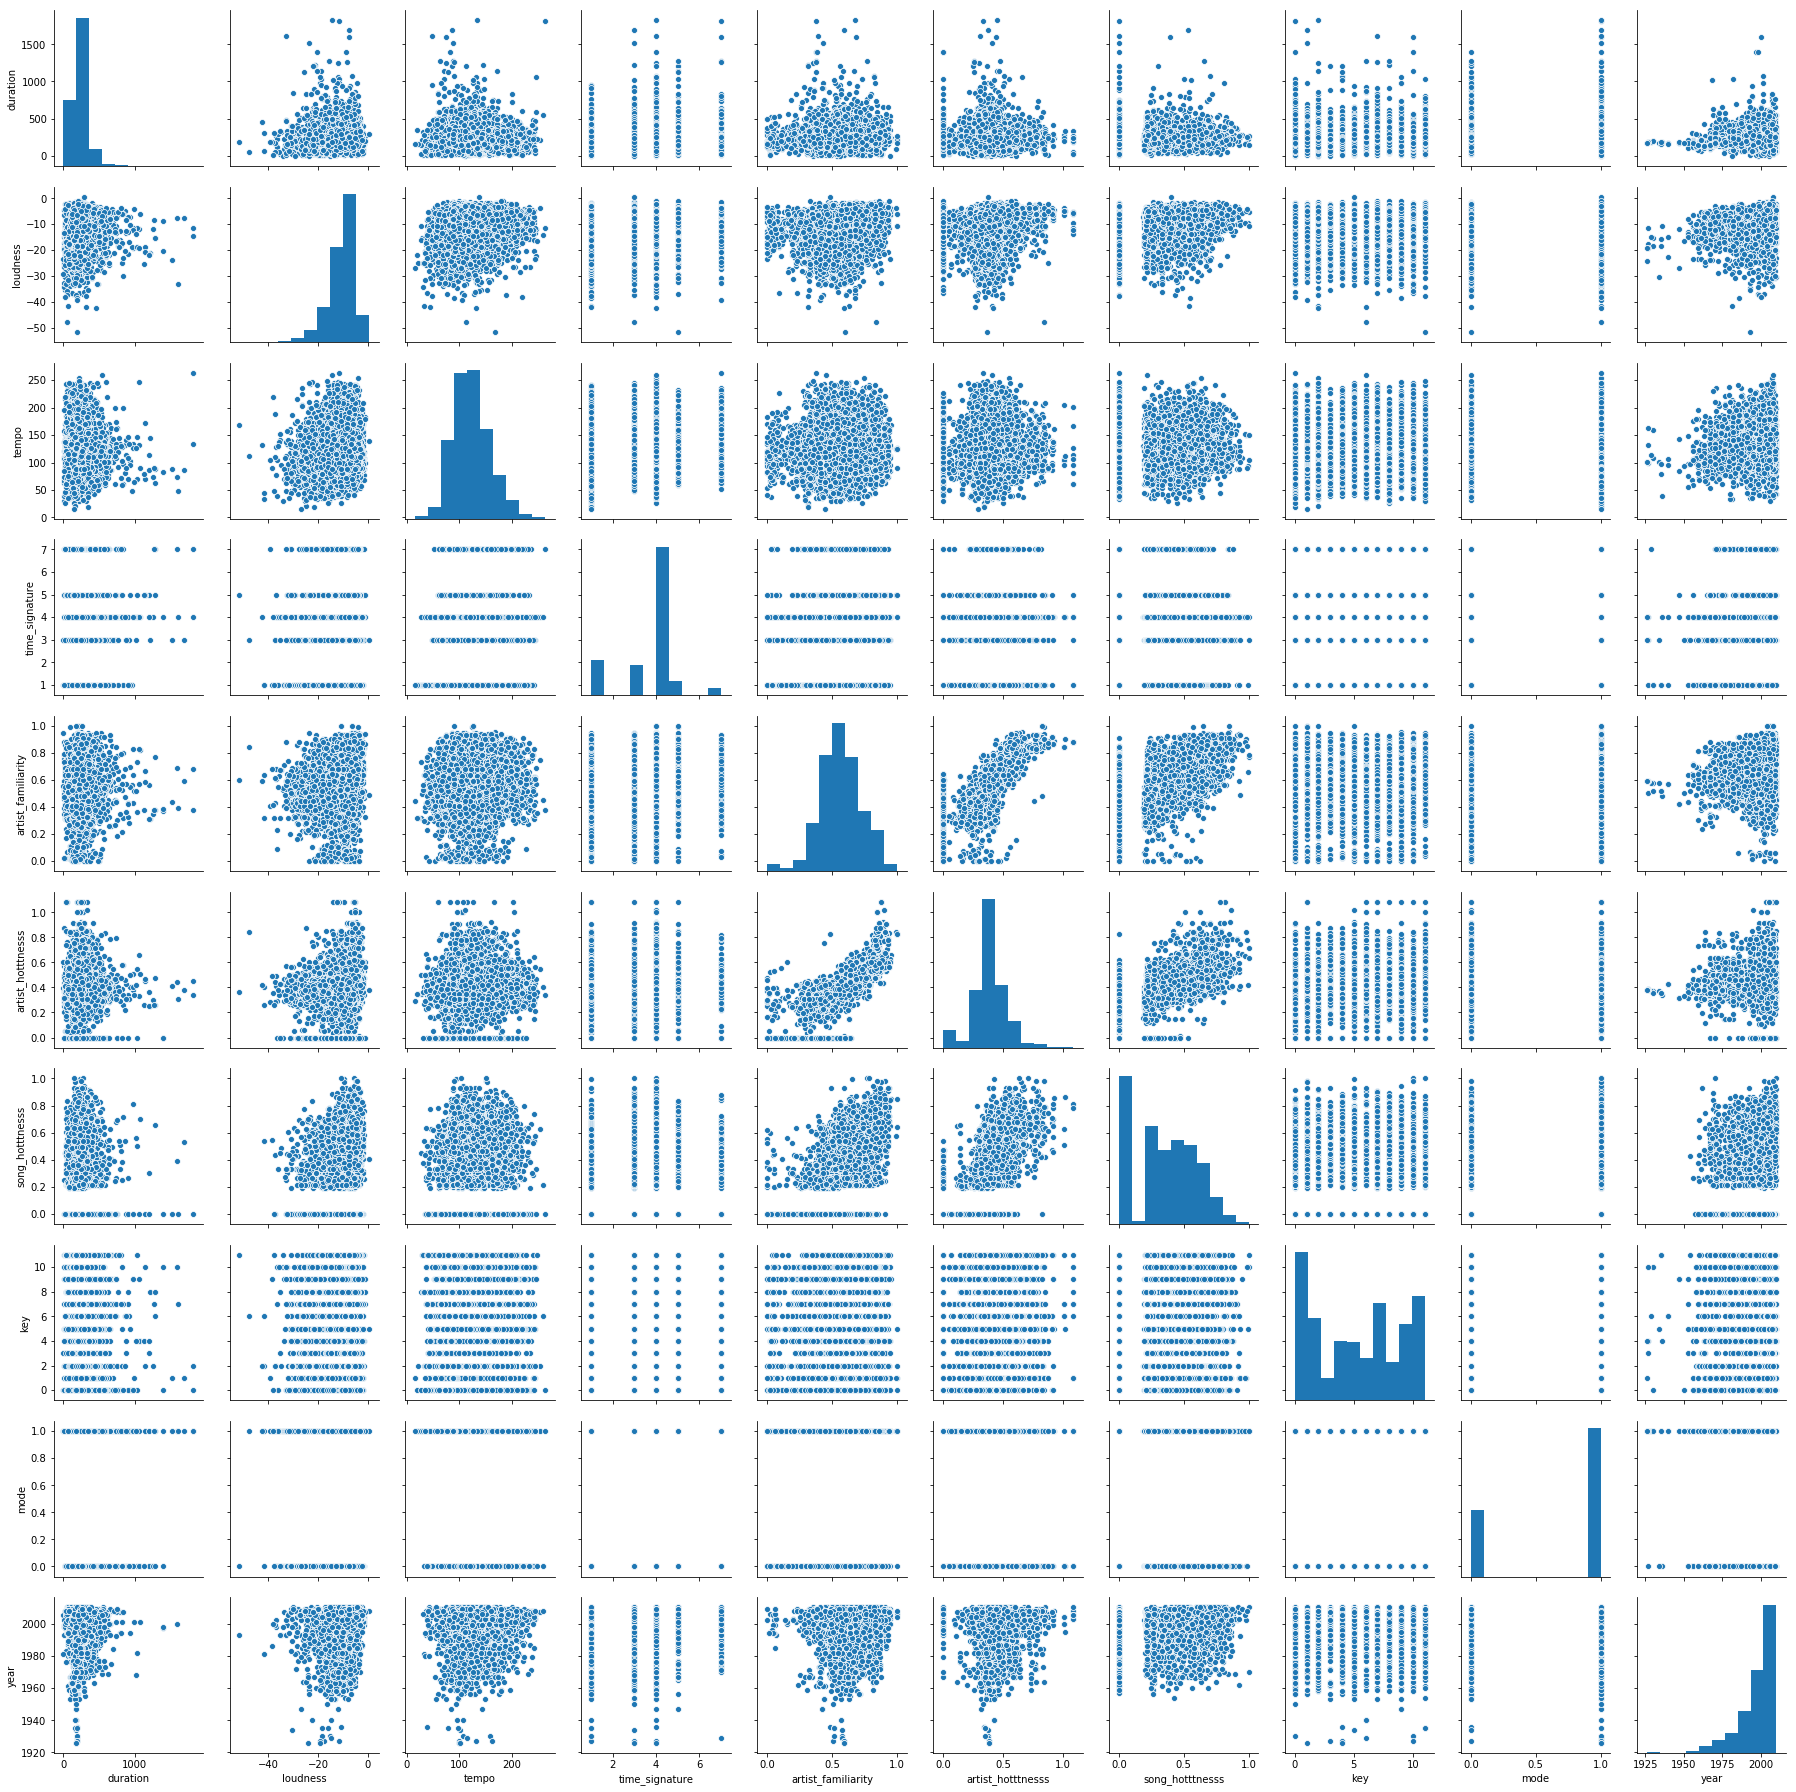

In [21]:
sns.pairplot(all_data)
plt.show()

Several of the plots in the scatter matrix above show interesting data that may require further investigation. There appears to be a correlation between artist_familiarity and artist_hotttnesss, which is not unexpected. Several of the histograms appear to be more or less normally distributed, but some (year, key, mode, etc) show more of an exponential distribution. Let's take a closer look at some of these plots:

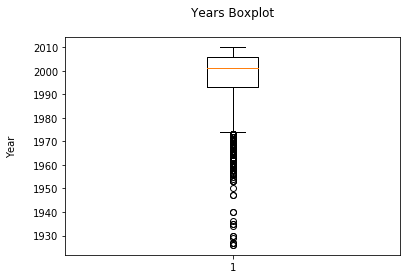

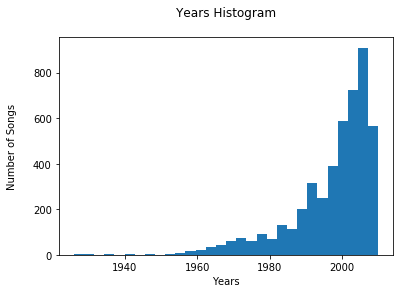

In [22]:
ig, ax = plt.subplots()
ax.tick_params(axis = 'both', which = 'major')
major_yticks = np.arange(1920, 2020, 10)
ax.set_yticks(major_yticks)

plt.boxplot(all_data['year'].dropna())

plt.title('Years Boxplot\n')
plt.xlabel('')
plt.ylabel('Year\n')
plt.show()

plt.hist(years, bins=30)
plt.xlabel('Years')
plt.ylabel('Number of Songs\n')
plt.title('Years Histogram\n')
plt.show()

The boxplot, also known as a box-and-whisker plot, shows how the datapoints are distributed within the years feature. Although I earlier determined that years had many NaN values, which may reduce its applicability, I decided to use it anyway, because it did have a significant enough number of usable values to show some interesting data. For example, this plot shows that although the song years range from the 1910s to the 2010s, the vast majority of the data is focused from around 1990 to 2005. The many outliers at the bottom of the plot and the fact that the box is not entirely symmetric indicate that there is is a skew of the data toward more recent years, while the lack of outliers at the top of the plot indicates that the year distribution stops abruptly at around 2011, which makes sense, because that's the year when this dataset was gathered. The histogram is provided as an alternative means of visualizing this data.

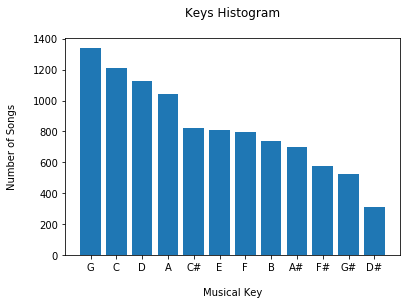

In [23]:
#Musical scale/ key names, in order
#Needed because dataset gave keys in values [0,11]
key_labels = ('C','C#','D','D#','E','F','F#','G','G#','A','A#','B') #order of C major scale provided by EchoNest

df_counts = all_data.groupby('key').size().reset_index(name='counts')
df_counts['key'] = key_labels
df_counts = df_counts.sort_values('counts', ascending=False)
df_counts = df_counts.reset_index(drop=True)
key_labels = list(df_counts['key'])  #reordered by count

#Plot hist
ig, ax = plt.subplots()

bars = ax.bar(df_counts.index[::-1], df_counts.counts[::-1])
ax.set_xticks(df_counts.index)
ax.set_xticklabels(key_labels)

plt.title('Keys Histogram\n')
plt.xlabel('\nMusical Key')
plt.ylabel('Number of Songs\n')
plt.show()

The keys of G, C, D, and A, ordered respectively, are the most popular among the songs represented in this random subset of the much larger Million Song Dataset, so it is safe to assume that most songs in general (or at least most songs that gain enough popularity to be included in a music dataset) are written in those keys.

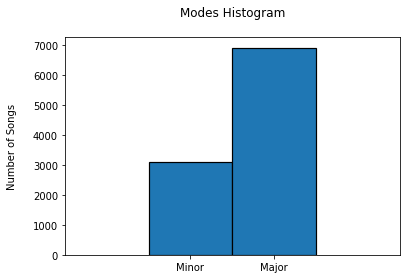

In [24]:
mode_labels = ('Minor', 'Major')

ig, ax = plt.subplots()

plt.hist(all_data['mode'], bins=range(3), edgecolor='black', linewidth=1.2)#, align = 'mid')
major_xticks = np.arange(0.5, 2.5, 1)
ax.tick_params(axis = 'both', which = 'major')
ax.set_xticks(major_xticks)
ax.set_xticklabels(mode_labels)
plt.xlim(-1, 3)
plt.title('Modes Histogram\n')
#plt.xlabel('\nMode')
plt.ylabel('Number of Songs\n')
plt.show()

Most songs are major, but a significant portion (approximately 1/3) are in minor, so it may be difficult to make a definitive statement regarding mode popularity.

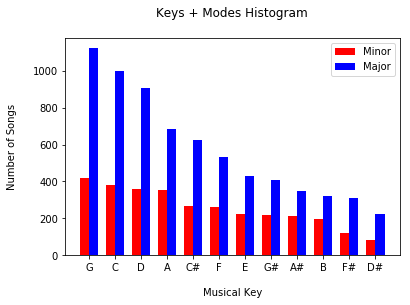

In [25]:
#Combined hist of modes and keys
ig, ax = plt.subplots()
colors = ['red', 'blue']

#plt.hist([all_data['key'][all_data['mode']==0], all_data['key'][all_data['mode']==1]], bins=range(13), edgecolor='black', linewidth=1.2, histtype='bar', color = colors)

key_labels = ('C','C#','D','D#','E','F','F#','G','G#','A','A#','B') #order of C major scale provided by EchoNest

minor_counts = all_data[all_data['mode']==0].groupby('key').size().reset_index(name='counts')
minor_counts['key'] = key_labels
minor_counts = minor_counts.sort_values('counts', ascending=False)
minor_counts = minor_counts.reset_index(drop=True)

major_counts = all_data[all_data['mode']==1].groupby('key').size().reset_index(name='counts')
major_counts['key'] = key_labels
major_counts = major_counts.sort_values('counts', ascending=False)
major_counts = major_counts.reset_index(drop=True)
key_labels = list(major_counts['key'])  #reordered by count

bar_w = 0.35

ax.bar(minor_counts.index[::-1] - (bar_w/2), minor_counts.counts[::-1], width = bar_w, color = colors[0], align = 'center')
ax.bar(major_counts.index[::-1] + (bar_w/2), major_counts.counts[::-1], width = bar_w, color = colors[1], align = 'center')
ax.set_xticks(major_counts.index)
ax.set_xticklabels(key_labels)

#major_xticks = np.arange(0.5, 12.5, 1)
#ax.tick_params(axis = 'both', which = 'major')
#ax.set_xticks(major_xticks)
#ax.set_xticklabels(key_labels)
#plt.xlim(-1, 13)
plt.title('Keys + Modes Histogram\n')
plt.xlabel('\nMusical Key')
plt.ylabel('Number of Songs\n')
plt.legend(mode_labels)
plt.show()

This visualization shows the popular keys again, this time split into bars by major vs. minor mode. Interestingly, it shows that the mode of the song has little to no effect on the popularity of the musical keys used.

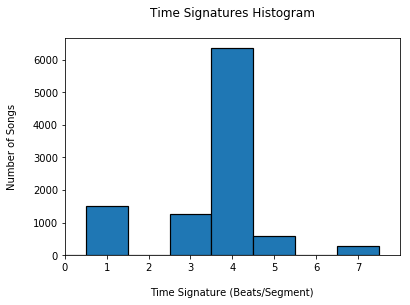

In [26]:
#Time Signature Histogram
ig, ax = plt.subplots()
ts_labels = (str(np.array(range(8)))[1:]).split(']')[0].split(' ')

plt.hist([all_data['time_signature']], bins=range(9), edgecolor='black', linewidth=1.2)

major_xticks = np.arange(0.5, 8.5, 1)
ax.tick_params(axis = 'both', which = 'major')
ax.set_xticks(major_xticks)
ax.set_xticklabels(ts_labels)
plt.xlim(0.5, 8.5)
plt.title('Time Signatures Histogram\n')
plt.xlabel('\nTime Signature (Beats/Segment)')
plt.ylabel('Number of Songs\n')
plt.show()

The majority of songs have 4 beats per segment. This time signature is known colloquially as "common time," and this result was to be expected.

C:\Users\Amichai\Anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Amichai\Anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


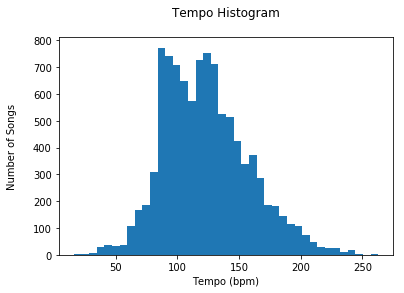

In [27]:
plt.hist(all_data['tempo'], bins=40)
plt.xlabel('Tempo (bpm)')
plt.ylabel('Number of Songs\n')
plt.title('Tempo Histogram\n')
plt.show()

Song tempo has an interesting distribution in that the distribution is somewhat normal (less common on the ends, more common in the middle), yet also contains two peaks, at around 80 bpm and 130 bpm. This is likely due to differences in genre of the music (rock vs. jazz, etc), but that's impossible to analyze using this dataset, as the genre feature was corrupted and contained no usable information. 

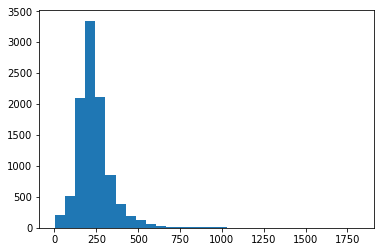

In [28]:
plt.hist(all_data['duration'], bins=30)
plt.show()

The duration of the songs has a large span of outliers between 600 and 1750 seconds, which indicates that although there are several very long songs, the most of the songs are approximately 240 seconds (4 minutes), and the vast majority of songs don't exceed a duration of 9-10 minutes. 

# 3. Analytic Questions

## Are the "familiarity" and "hotness" of an artist correlated?

In [29]:
# Function to create a scatter plot with a trendline
def trendScat(all_data, y_var,y_str,y_units,x_var,x_str, unique):
    df_counts = all_data.groupby([x_var, y_var]).size().reset_index(name='counts')
    plt.scatter(df_counts[x_var], df_counts[y_var], s=df_counts.counts*20, color='blue')

    plt.xlabel('\n'+ x_str)
    plt.ylabel(y_str + ' ' + y_units + '\n')
    plt.title(x_str + ' vs. ' + y_str + ' - Scatter Plot\n(Marker Size = Overlapping Points)')

    unique = [x for x in unique if ~np.isnan(x)]    

    #Average all y_var per unique x_var
    averaged = []
    for i in range(len(unique)):
        averaged.append(np.nanmean(all_data[y_var][round(all_data[x_var],2) == unique[i]]))

    #Remove Nans from both arrays
    for j in range(len(np.where(np.isnan(averaged))[0])):
        unique.pop(np.where(np.isnan(averaged))[0][-j])
    averaged = [x for x in averaged if ~np.isnan(x)]

    # calculate polynomial
    z = np.polyfit(unique, averaged, 2)
    f = np.poly1d(z)

    # calculate new x's and y's
    x_new = np.linspace(unique[0], unique[-1], 2)
    y_new = f(x_new)
            
    plt.plot(x_new, y_new, color = 'red', label = 'Averaged Trendline')
    plt.show()


C:\Users\Amichai\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice
  from ipykernel import kernelapp as app


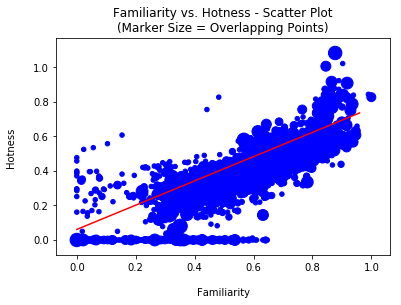

In [30]:
## Are familiarity and hotttnesss related to each other?
unique = list(np.arange(0,1,0.01))   #Sizable range of potential values within artist_familiarity
unique_initial = [round(x,2) for x in unique if ~np.isnan(x)]     #normalize if values have weird number of decimals

trendScat(all_data, 'artist_hotttnesss','Hotness', '','artist_familiarity', 'Familiarity', unique = unique_initial)

Although it may seem obvious that familiarity and hottness have a correlation, it's nice to have a visualization that backs it up, especially one that shows that the correlation is more or less linear in nature. Also important to note is that this linear correlation skews somewhat in favor of Familiarity over Hottness, in that the slope of the trendline is less than 1. This means that while people are more likely to report that they are familiar with an artist than that they like the artist's work, those who report low familiarity also tend to report low levels of hottness, and vice-versa.

## How (if at all) have trends in song loudness, speed, and length changed over time?

C:\Users\Amichai\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice
  from ipykernel import kernelapp as app


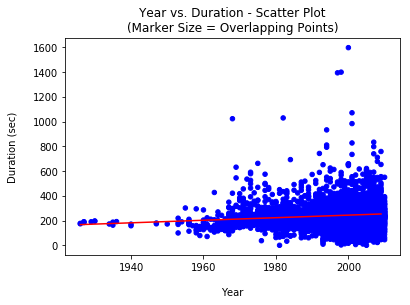

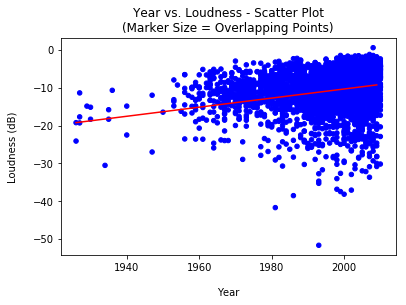

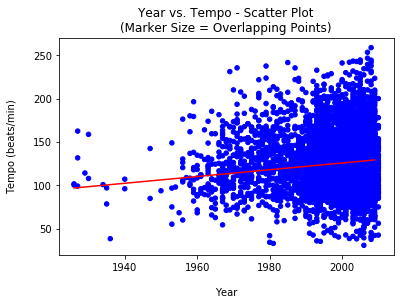

In [31]:
## Trends in loudness, speed, and length of song over time
unique_initial = list(np.arange(min(all_data['year']), max(all_data['year']),1))   #Range of all potential values within artist_familiarity

trendScat(all_data, 'duration','Duration', '(sec)','year', 'Year', unique = unique_initial)
trendScat(all_data, 'loudness','Loudness', '(dB)', 'year', 'Year', unique = unique_initial)
trendScat(all_data, 'tempo','Tempo', '(beats/min)', 'year', 'Year', unique = unique_initial)

The above plots all show a positive correlation between more recent years and duration, loudness, and tempo, although the positive correlation between duration and year is far less distinct than the other two. In other words, songs from the earlier years tend to be much slower and quieter than those from recent years, and recent songs tend to be slightly longer than earlier ones, although the difference is likely too small to be statistically significant. 

## Does hottness and/or familiarity correlate to the number of songs an artist produces?

In [32]:
#Which artists were most popular?
print("Most Songs: ")
print((all_data['artist_name'].value_counts()).head())

print("\nHighest Hottness: ")
print(all_data['artist_name'][all_data['artist_hotttnesss']>0.94])

print("\nHighest Familiarity: ")
print(all_data['artist_name'][all_data['artist_familiarity']>0.94])

Most Songs: 
Mario Rosenstock             13
Phil Collins                 12
Sugar Minott                 12
Aerosmith                    12
The Jackson Southernaires    12
Name: artist_name, dtype: int64

Highest Hottness: 
554              Black Eyed Peas / Terry Dexter
699                                  Kanye West
715                    Kanye West / Adam Levine
1163                            Black Eyed Peas
1374         Kanye West / Consequence / Cam'Ron
2378                                 Kanye West
2858                            Black Eyed Peas
3853    Black Eyed Peas / Les Nubians / Mos Def
4184                                 Kanye West
5708                                 Kanye West
6991                   Kanye West / Lupe Fiasco
7048                                  Daft Punk
7997                                 Kanye West
8864                            Black Eyed Peas
9288                                 Kanye West
Name: artist_name, dtype: object

Highest Familiarity: 

These printouts show that there seems to be very little to no correlation between hotness, familiarity, and number of songs produced. An issue with this conclusion is that some of the artist_name features should be categorized as the same artist (such as Kanye West and Kanye West/Adam Levine), but since I don't have a way of finding every possible combination of artist names, I wasn't sure how to split them up properly. Still, even without proper categorization, we can see in this data that the artists with the highest hottness levels include Kanye West, Adam Levine, Black Eyed Peas, and a few others, and the artists with the highest familiarity contain Britney Spears, Avril Lavigne, and Akon. None of the high-scorers among familiarity or hottness fall into the list of artists who produced the highest numbers of songs, so there is no obvious correlation.

# 4. Future Research

As mentioned earlier, this dataset was flawed in a few ways. Firstly, several of the variables (including genre, arguably one of the most important when developing a classification model) were missing or otherwise corrupted to the extent that they were unusable. For future projects, I would want to either find some way to extract those features properly or choose a dataset that contained similar features in a usable format. 

Another potential issue with using this dataset is that it was only a subset of a much larger dataset. Although 10,000 rows is a good size for visualization purposes, once we move on to classification and machine learning, I will probably need to work with the full range of data, which means I won't be able to use a Jupyter Notebook, as it kept freezing my computer when I tried to use it for this analysis. Alternatively, I would have to use an entirely different dataset that had similar features and a greater number of songs. 

Another concept I could investigate is splitting up the data properly based on artist or location name. As mentioned earlier, some of those variables overlapped (i.e. Los Angeles, CA vs. Los Angeles vs. Los Angeles, California). With a properly sorted dataset, interesting correlations may arise that indicate which artists are most successful, where the most successful songs were produced, and much more.